## Challenge Description

Company XYZ sells a software for 39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 0.66 of the users have seen the old price (39), while a random sample of 0.33 users a higher price (59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. Especially she asked you the following questions:

1. Should the company sell its software for $39 or $59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and she should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days would you have stopped the test? Please, explain why.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.model_selection import GridSearchCV# for tuning parameter
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm # for Support Vector Machine
from sklearn import metrics # for the check the error and accuracy of the model

In [24]:
# Importing librarys to use on interactive graphs

import plotly.graph_objs as go 
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [85]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer


In [2]:
results = pd.read_csv('test_results.csv', index_col= 0)
user = pd.read_csv('user_table.csv')

## Exploratiry Data Analysis

In [7]:
results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           316800 non-null  int64  
 1   timestamp         316466 non-null  object 
 2   source            316488 non-null  object 
 3   device            316800 non-null  object 
 4   operative_system  296461 non-null  object 
 5   test              316800 non-null  int64  
 6   price             316800 non-null  float64
 7   converted         316800 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 21.8+ MB


In [11]:
print(results['source'].unique())
print(results['device'].unique())
print(results['operative_system'].unique())

['ads_facebook' 'seo-google' 'ads-bing' 'direct_traffic' 'ads-google'
 'seo_facebook' 'friend_referral' 'ads_other' 'ads-yahoo' 'seo-yahoo'
 'seo-bing' 'seo-other' nan]
['mobile' 'web']
['iOS' 'android' 'mac' 'windows' nan 'i0S' 'wnddows' 'anroid' 'apple']


In [5]:
results['operative_system']=results['operative_system'].map({'wnddows':'windows','anroid':'android','i0S':'iOS'})

In [6]:
results['operative_system'].unique()

array([nan, 'iOS', 'windows', 'android'], dtype=object)

In [9]:
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [10]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [14]:
len(user['city'].unique())

923

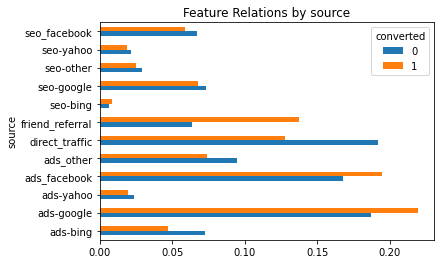

In [173]:
# Check Converted customer by source and compare to the whole population
results.groupby('converted').source.value_counts(normalize=True, ascending=True).unstack(0).plot.barh()
plt.title('Customers  by source')
plt.show()

In [180]:
results.groupby('converted').source.value_counts(normalize=True, ascending=True).unstack(0)

converted,0,1
source,,
ads-bing,0.072669,0.047184
ads-google,0.186825,0.219735
ads-yahoo,0.024015,0.019287
ads_facebook,0.168034,0.194937
ads_other,0.094695,0.073876
direct_traffic,0.191721,0.127949
friend_referral,0.063963,0.137765
seo-bing,0.006753,0.008783
seo-google,0.073278,0.067849


Ads campgion including ads on facebook (2.6%) and google (3.3%) have increased conversion rates. Friend referral is the most effective way, with more then 2x increase, in successfully promoting customer conversions.

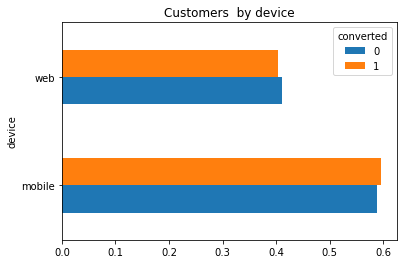

In [175]:
# Check Converted customer by device and compare to the whole population
results.groupby('converted').device.value_counts(normalize=True, ascending=True).unstack(0).plot.barh()
plt.title('Customers  by device')
plt.show()

Converted customers did not show device perferance differences.

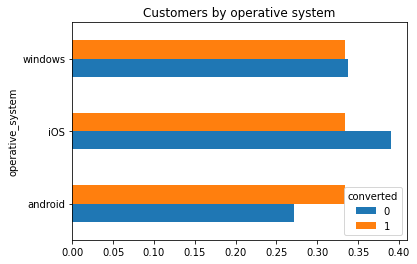

In [177]:
# Check Converted customer by source and compare to the whole population
results.groupby('converted').operative_system.value_counts(normalize=True, ascending=True).unstack(0).plot.barh()
plt.title('Customers by operative system')
plt.show()

Converted customers showed slightly perferance on Android rather than apple IOS.

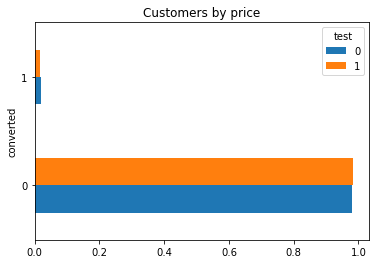

In [4]:
# Check Converted customer by price and compare to the whole population
results.groupby('test').converted.value_counts(normalize=True, ascending=True).unstack(0).plot.barh()
plt.title('Customers by price')
plt.show()

In [6]:
results.groupby('test').converted.value_counts(normalize=True, ascending=True).unstack(0)

test,0,1
converted,,
0,0.980096,0.984457
1,0.019904,0.015543


Customers with higher price charged has slightly reduced conversion rate (0.44% drop), but it caused 23.4% total rerenue increase compared to original price.
### Qustion 1
As strategy to have highest total revenue, this company should sell its software for 59. Since at higher price, the conversion rate slightly dropped, but the total revenue increased from 741 to 975 per 1000 users. 

Number of test with higher price:  114073
Number of non-test with old price :  202727


C:\Users\Wanchen\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


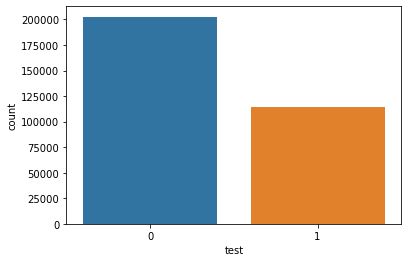

In [10]:
ax = sns.countplot(results['test'],label="Count")       
L, H = results['test'].value_counts()
print('Number of test with higher price: ',H)
print('Number of non-test with old price : ',L)

Number of customer converted:  5808
Number of customer not converted:  310992


C:\Users\Wanchen\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


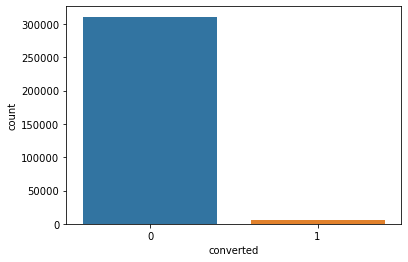

In [11]:
ax = sns.countplot(results['converted'],label="Count")       
NC, C = results['converted'].value_counts()
print('Number of customer converted: ',C)
print('Number of customer not converted: ',NC)

In [12]:
# Chekc whether there is duplicated rows
results.duplicated().sum()

0

In [13]:
user.duplicated().sum()

0

## Check time trend of conversion

In [ ]:
# Merge two datasets on user_id
df=results.merge(user, on = 'user_id', how='outer')

In [31]:
df['year'] = 2015
df['date'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')

In [32]:
s = df['timestamp'].str.split('-')

#df['date'] = pd.to_datetime(s.str[0]) + pd.to_timedelta(s.str[1])

df['month'] = s.str[1]
df['day'] = s.str[2].apply(lambda x: str(x).split(' ')[0])
df.head()


,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,month,day,year,date,weekday
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86,05,08,2015,2015-05-08,4.0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24,05,10,2015,2015-05-10,6.0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73,04,04,2015,2015-04-04,5.0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90,05,07,2015,2015-05-07,3.0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02,05,24,2015,2015-05-24,6.0


In [33]:
df["weekday"] = df['date'].dt.weekday #extracting week day
df["day"] = df['date'].dt.day # extracting day
df["month"] = df['date'].dt.month # extracting day


In [34]:
print(df.groupby('month').day.unique())

month
3.0    [4.0, 15.0, 28.0, 21.0, 22.0, 16.0, 8.0, 5.0, ...
4.0    [4.0, 13.0, 24.0, 17.0, 25.0, 15.0, 2.0, 5.0, ...
5.0    [8.0, 10.0, 7.0, 24.0, 15.0, 29.0, 3.0, 31.0, ...
Name: day, dtype: object


In [36]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace
#s = df['timestamp'].str.split('-')

#df['date'] = pd.to_datetime(s.str[0]) + pd.to_timedelta(s.str[1])

#2015-05-08 03:38:34
#df['date'] = df['timestamp'].apply(lambda x: datetime.date(2015, int(str(x)[5:7]), 1)+date.timedelta(days=int(str(x)[8:10])-1))

cnt_srs = df.groupby('converted').date.value_counts().unstack(0)
#df[df['converted']==1].groupby('day').date.agg(['count'])
cnt_srs.columns = ["Unconverted customers", "Converted customers"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["Unconverted customers"], 'red')
trace2 = scatter_plot(cnt_srs["Converted customers"], 'blue')
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Unconverted customers", "Date - Converted customers count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

In [38]:
def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace
#s = df['timestamp'].str.split('-')

#df['date'] = pd.to_datetime(s.str[0]) + pd.to_timedelta(s.str[1])

#2015-05-08 03:38:34
#df['date'] = df['timestamp'].apply(lambda x: datetime.date(2015, int(str(x)[5:7]), 1)+date.timedelta(days=int(str(x)[8:10])-1))

cnt_srs = df.groupby('converted').weekday.value_counts().unstack(0)
#df[df['converted']==1].groupby('day').date.agg(['count'])
cnt_srs.columns = ["Unconverted customers", "Converted customers"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["Unconverted customers"], 'red')
trace2 = scatter_plot(cnt_srs["Converted customers"], 'blue')
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Unconverted customers", "Date - Converted customers count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

## Inferences:

We have data from 1 March, 2015 to 31 May, 2015 in our dataset.
There is abvious an cyclic trend that increasing users views on Thursday-Saturday, which peaks on Thursday. Also users conversion increased during 30 March to 28 April, which peak around April 16-27.

# User distributions

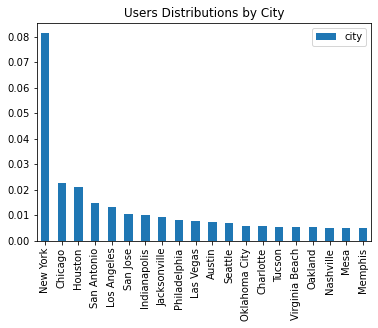

In [64]:
# Plot the top 20 cities with most users
city_tree = pd.DataFrame(df["city"].value_counts(sort=True,ascending=False)) #counting 

(city_tree[:20]/df.shape[0]).plot(kind = 'bar')
plt.title('Users Distributions by City')
plt.show()

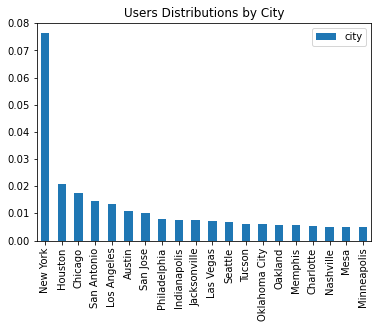

In [69]:
# Plot the top 20 cities with most users
df_converted = df[df["converted"]==1]
city_tree_conv = pd.DataFrame(df_converted["city"].value_counts(sort=True,ascending=False)) #counting 

(city_tree_conv[:20]/df_converted.shape[0]).plot(kind = 'bar')
plt.title('Users Distributions by City')
plt.show()

Users are mostly in New York (~8%), Chicago(~2%), Houston(~2%)

## Assess Missing Data in Each Column
How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. Here I used matplotlib's function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project I just remove them from the dataframe.

In [75]:
# Perform an assessment of how much missing data there is in each column of the dataset.

def extract_columns_with_nan(df):

    # Extract columns with NaNs
    columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]

    # Calculate percentage of NaN for each column
    dic_nan = {'sum': columns_with_nans.values, 'percent': np.round(columns_with_nans.values * 100 / df.shape[0], 2)}

    # Build a dataframe including only columns with NaNs
    df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)

    # Sort by percentage
    df_nan.sort_values(by='percent', ascending=False, inplace=True)

    return df_nan

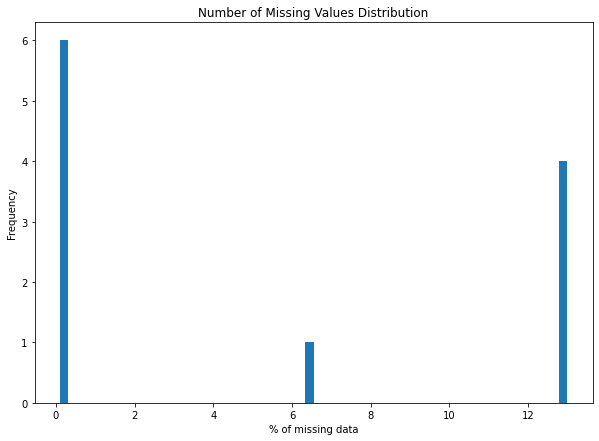

In [76]:
df_nan = extract_columns_with_nan(df)
#Investigate patterns in the amount of missing data in each column.

df_nan['percent'].plot(kind = 'hist', figsize = (10, 7), bins = 60,
                                            title = 'Number of Missing Values Distribution')

plt.xlabel('% of missing data')   ;

All columns have less than 15% missing values.

Text(0.5, 0, 'Number of Missing Values')

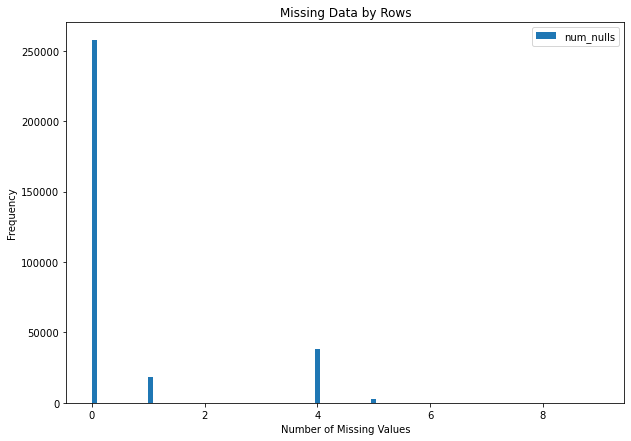

In [77]:
df_null_row = pd.DataFrame(df.isnull().sum(axis = 1))
df_null_row.columns = ['num_nulls']
df_null_row.plot(kind = 'hist', bins = 100, figsize = (10, 7), title ='Missing Data by Rows')
plt.xlabel('Number of Missing Values')

In [78]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,month,day,year,date,weekday
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86,5.0,8.0,2015,2015-05-08,4.0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24,5.0,10.0,2015,2015-05-10,6.0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73,4.0,4.0,2015,2015-04-04,5.0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90,5.0,7.0,2015,2015-05-07,3.0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02,5.0,24.0,2015,2015-05-24,6.0


# Re-Encode Categorical Features
Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I made few encoding changes or additional assumptions to be able to make progress. I perform an investigation of the categorical features. Then create a new data frame with only the selected and engineered columns.

For categorical data, I encode the levels as dummy variables. Depending on the number of categories, perform one of the following:For multi-level categoricals (three or more values), encode the values using multiple dummy variables (via [OneHotEncoder]


In [79]:
cate_encode = ['source','device','city','operative_system','day','month','weekday']
df_dummies = pd.get_dummies(df, columns=cate_encode, dummy_na = True)

In [274]:
df_factorize = df.copy()

In [280]:
for col in df.columns:
    if col in ['month', 'weekday', 'day']: continue
    if df[col].dtypes == object or df[col].dtypes == bool:
        df_factorize[col], indexer = pd.factorize(df[col])

In [289]:
df_factorize.columns[df_factorize.isna().any()].tolist()

['lat', 'long', 'date']

In [290]:
df_factorize['lat'] = df_factorize['lat'].fillna(0)
df_factorize['long'] = df_factorize['long'].fillna(0)

In [291]:
df_factorize.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,month,day,date,year,weekday
0,604839,0,0,0,-1,0,39.0,0,0,0,42.89,-78.86,5.0,8.0,2015-05-08,2015,5.0
1,624057,1,1,0,-1,0,39.0,0,1,0,44.68,-93.24,5.0,10.0,2015-05-10,2015,5.0
2,317970,2,2,0,-1,0,39.0,0,2,0,41.38,-81.73,4.0,4.0,2015-04-04,2015,4.0
3,685636,3,3,0,-1,1,59.0,0,3,0,35.07,-78.90,5.0,7.0,2015-05-07,2015,5.0
4,820854,4,0,1,-1,0,39.0,0,4,0,39.95,-86.02,5.0,24.0,2015-05-24,2015,5.0


## Data Splitting
Define features and target and seperate into arrays

In [292]:
y = df_factorize['converted']
x = df_factorize.drop(['converted','price','timestamp','country','user_id','date'],axis = 1 )

In [293]:
#now split our data into train and test
#train, test = train_test_split(df, test_size = 0.3)# in this our main data is splitted into train and test


# Seperate dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1) # 20% test
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 20% val
# we can check their dimension
print(X_train.shape)
print(X_test.shape)

(190080, 11)
(63360, 11)


## Model selection
#### Random Forest

In [294]:
model_rf=RandomForestClassifier(n_estimators=100)# a simple random forest model
model_rf.fit(X_train,y_train)
prediction=model_rf.predict(X_test)

In [295]:
metrics.fbeta_score(prediction,y_test, beta = 0.5)

0.005333902282910178

<Figure size 432x288 with 0 Axes>

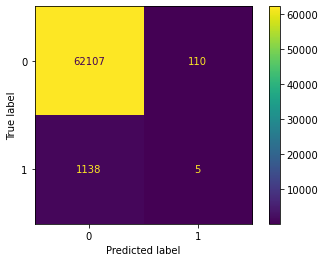

In [296]:
# Compute confusion matrix
y_test_pred = model_rf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred)

# Plot non-normalized confusion matrix
plt.figure()
metrics.plot_confusion_matrix(model_rf, X_test, y_test)

In [213]:
!pip install lightgbm

In [297]:
import lightgbm as lgb
# custom function to run light gbm model
def run_lgb(X_train, y_train, X_validation, y_validation, X_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_validation, label=y_validation)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(X_test, num_iteration=model.best_iteration)
    pred_val_y = model.predict(X_validation, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(X_train, y_train, X_validation, y_validation, X_test)

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.134416
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.134332


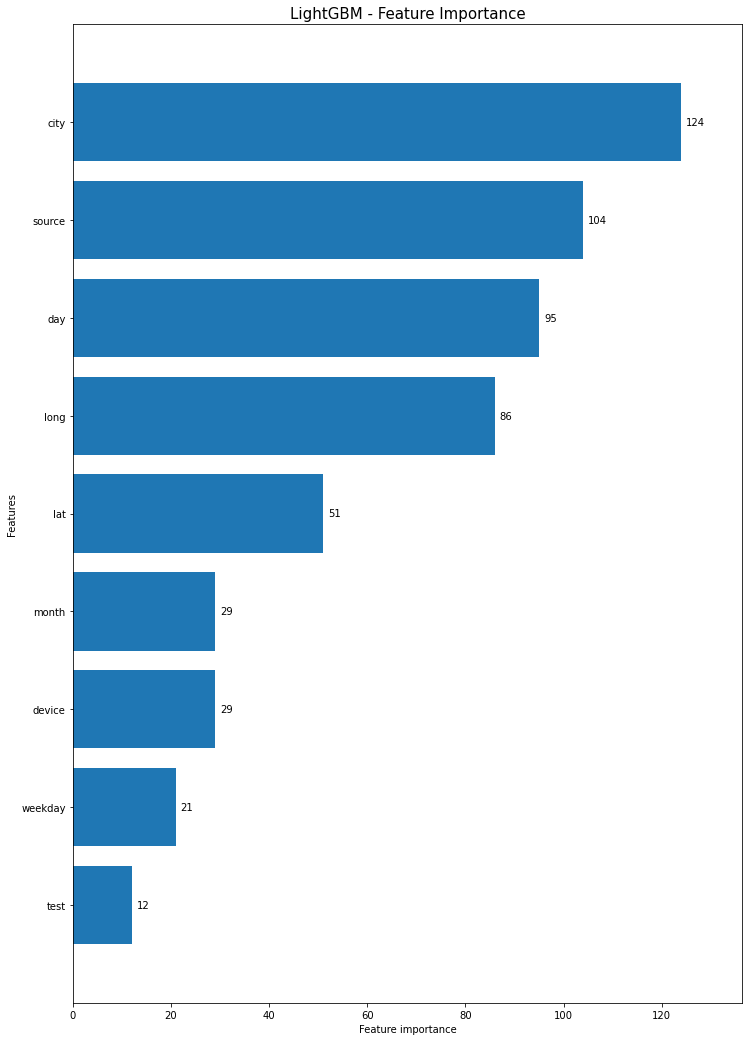

In [298]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## Qestion2
The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

Suggestions:
1. City has greatest impact on user conversion. May consider increase ads promotion in major cities, like New York, Chicago, Houston.
2. Friend referral is the most effective source for user conversion. Maybe consider offering bonus or discount for successful friend referral. Increase Advertising through Facebook and google, while considering reduce Advertising cost on bin and yahoo.
3. Increase these mentioned promotions or advertising on Thursday and Friday, when more users are visiting.

## Question 3: Sample size calculation

In [126]:
import scipy.stats as stats

import math


In [140]:
df['date'].dtype

dtype('<M8[ns]')

In [154]:
base = datetime.datetime(2015,3,1)
date_list = sorted(df['date'].unique())
date_list


[numpy.datetime64('2015-03-02T00:00:00.000000000'),
 numpy.datetime64('2015-03-03T00:00:00.000000000'),
 numpy.datetime64('2015-03-04T00:00:00.000000000'),
 numpy.datetime64('2015-03-05T00:00:00.000000000'),
 numpy.datetime64('2015-03-06T00:00:00.000000000'),
 numpy.datetime64('2015-03-07T00:00:00.000000000'),
 numpy.datetime64('2015-03-08T00:00:00.000000000'),
 numpy.datetime64('2015-03-09T00:00:00.000000000'),
 numpy.datetime64('2015-03-10T00:00:00.000000000'),
 numpy.datetime64('2015-03-11T00:00:00.000000000'),
 numpy.datetime64('2015-03-12T00:00:00.000000000'),
 numpy.datetime64('2015-03-13T00:00:00.000000000'),
 numpy.datetime64('2015-03-14T00:00:00.000000000'),
 numpy.datetime64('2015-03-15T00:00:00.000000000'),
 numpy.datetime64('2015-03-16T00:00:00.000000000'),
 numpy.datetime64('2015-03-17T00:00:00.000000000'),
 numpy.datetime64('2015-03-18T00:00:00.000000000'),
 numpy.datetime64('2015-03-19T00:00:00.000000000'),
 numpy.datetime64('2015-03-20T00:00:00.000000000'),
 numpy.datet

In [160]:
def timespan(df):

    date_list =sorted(df['date'].unique())
    for time in date_list[1:3]:
        visit_day = df[df['date']<=time]
        test_Reve = visit_day[(visit_day['test'] == 1) & (visit_day['converted'] == 1)].shape[0]*59
        contr_Reve = visit_day[(visit_day['test'] == 0) & (visit_day['converted'] == 1)].shape[0]*39
        t, p = stats.ttest_ind(test_Reve, contr_Reve, equal_var=False)
        n = df.shape[0]
        print("ttest_ind: t = %g  p = %g  n = %g" % (t, p, n))
        if p <0.05:
            break
        return time
timespan(df);

ttest_ind: t = nan  p = nan  n = 316800


C:\Users\Wanchen\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3622: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Wanchen\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



The key point to notice is that, for an $\alpha$ and $\beta$ both < .5, the critical value for determining statistical significance will fall between our null conversion rate and our alternative, desired conversion rate. So, the difference between $p_0$ and $p_1$ can be subdivided into the distance from $p_0$ to the critical value $p^*$ and the distance from $p^*$ to $p_1$.

In [124]:
def z_calc(p_null, p_alt, n1, n2):
    p_star = (p_null*n1 + p_alt*n2) / (n1 + n2)
    return abs(p_null - p_alt) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

In [128]:

def sample_required(p_null, p_alt, test_ratio, alpha = .05, beta = .20):
    p_diff = abs(p_null-p_alt)
    n = 1
    while True:
        z = z_calc(p_null, p_alt, n*(1-test_ratio), n*test_ratio)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

# def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
   
#     # Get necessary z-scores and standard deviations (@ 1 obs per group)
#     z_null = stats.norm.ppf(1 - alpha)
#     z_alt  = stats.norm.ppf(beta)
#     sd_null = np.sqrt(p_null * (1-p_null) + p_null * (1-p_null))
#     sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt  * (1-p_alt) )
    
#     # Compute and return minimum sample size
#     p_diff = p_alt - p_null
#     n = ((z_null*sd_null - z_alt*sd_alt) / p_diff) ** 2
#     return np.ceil(n)

In [99]:
df_notest = df[df['test'] ==0]
df_test = df[df['test'] ==1]

In [100]:
p_null = df_notest[df_notest['converted']==1].shape[0]/df_notest.shape[0]
print(p_null)

0.019903614220108817


In [101]:
p_alt = p_null*39/59
print(p_alt)

0.013156626348885488


In [129]:
sample_required(p_null, p_alt, 0.33)


4668

Calcuale the average number of visitors per day

In [107]:
max(df['date'])-min(df['date'])

Timedelta('90 days 00:00:00')

In [109]:
visit_per_day = df.shape[0]/90
print(visit_per_day)

3520.0


In [ ]:
exp_length = 

From the time span, converstion rate increase 